## Example 5: Extractive Distillation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
import utils.AntoineEquation as AE
from IPython.display import clear_output
from tqdm import tqdm
from distillation.DistillationDoubleFeed import *
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, Button, VBox, HBox, Output
from IPython.display import clear_output
from thermo_models.VanLaarModel import *
from distillation.residue_curves import *

In [2]:
#Acetone (1 - Light) Methanol (2 - Intermediate) Water (3 - Heavy)
#Table A.6 in Knapp 
A_ij = {
    (1,1):0,
    (1,2):182.0,
    (1,3):795.0,
    (2,1):196,
    (2,2):0,
    (2,3):332.6,
    (3,1):490.0,
    (3,2):163.80,
    (3,3):0
}

#Different definition of Antoine where we have to take the negative of B
Acet_A = 21.3099; Acet_B = 2801.53; Acet_C = -42.875
Meth_A = 23.4832; Meth_B = 3634.01; Meth_C = -33.768
#Assuming P < 2 atm
Water_A = 23.2256; Water_B = 3835.18; Water_C = -45.343

#Kanapp Thesis Figure 3.8 uses ln form of Antoine
AcetoneAntoine = AE.AntoineEquationBaseE(Acet_A,Acet_B,Acet_C)
MethanolAntoine = AE.AntoineEquationBaseE(Meth_A, Meth_B, Meth_C)
WaterAntoine = AE.AntoineEquationBaseE(Water_A,Water_B,Water_C)
        
P_sys = 101325
# Create a Raoult's law object
AceMethWaterSys = VanLaarModel(num_comp = 3, P_sys = P_sys, A_coeff = A_ij, comp_names = ["Acetone","Methanol","Water"], partial_pressure_eqs = [AcetoneAntoine, MethanolAntoine, WaterAntoine])


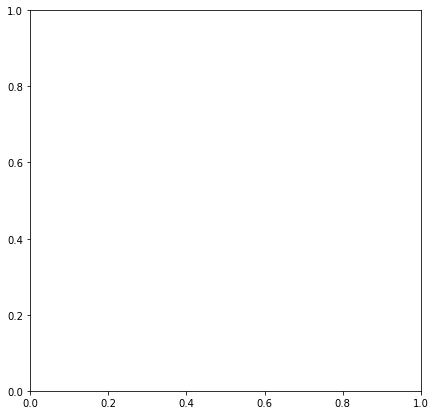

In [3]:
out_residue = Output()
rcm = residue_curve(AceMethWaterSys)
fig, ax = plt.subplots(1,1,figsize= (7,7))
#rcm.plot_residue_curve_og(ax,15)

#### Demo 2

In [13]:
zF = np.array([0.25, 0.35, 0.4])
xFL = np.array([0.3, 0.6, 0.1])
xFU = np.array([0.2, 0.1, 0.7])
xD = np.array([0.89, 0.05, 0.06]) 
xB = np.array([0.01, 0.40,0.59])
R = 3
Fr = 2.5
distillation_model = DistillationModelDoubleFeed(AceMethWaterSys, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)

# Create widgets
middle_start_set = widgets.Dropdown(
    options=[5, 10, 15, 20],
    description='Set the Starting Point of the Middle Section:',
    disabled=False
)

# Create an interactive plot function
def interactive_plot(middle_start):
    fig, ax = plt.subplots(1, 1, figsize=(5, 10))
    distillation_model.plot_rect_strip_comp(ax, middle_start=middle_start)
    plt.show()

# Create a dropdown widget for middle_start
middle_start_widget = widgets.Dropdown(
    options=[2, 4, 6, 8, 10],
    description='Middle Section Start:',
    disabled=False
)

# Create an interactive plot with the dropdown widget
interactive(interactive_plot, middle_start=middle_start_widget)

interactive(children=(Dropdown(description='Middle Section Start:', options=(2, 4, 6, 8, 10), value=2), Output…

### Demo 3
A maximum reflux ration exists, around R=60?

In [18]:
R_slider =  widgets.FloatSlider(value=0.1, min=0, max=100, step=0.001,  description='Reflux Ratio:', readout_format='.1f')
go_button = widgets.Button(description='Create Model', width='15%', margin='0 10px 0 0')
out_middle = Output()

def plot_reflux_demo_ex5(R = R_slider):
    plt.close('all')  # Ensure that any existing figures are closed before plotting a new one.
    zF = np.array([0.25, 0.35, 0.4])
    xFL = np.array([0.3, 0.6, 0.1])
    xFU = np.array([0.2, 0.1, 0.7])
    xD = np.array([0.89, 0.05, 0.06]) 
    xB = np.array([0.01, 0.40,0.59])
    middle_start = 6
    distillation_model = DistillationModelDoubleFeed(AceMethWaterSys, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)
    fig, ax = plt.subplots(1,1,figsize= (5,10))
    distillation_model.plot_rect_strip_comp(ax, middle_start=middle_start)
    plt.subplots_adjust(hspace=0)
    plt.show()



def on_go_button_click(b):
    with out_middle:
        clear_output(wait=True)
        plt.close('all')  # Close all open matplotlib plots
        plot_reflux_demo_ex5(R=R_slider.value)
        
go_button = Button(description='Generate Plot')
go_button.on_click(on_go_button_click)

layout = VBox([HBox([R_slider, go_button]), out_middle])
display(layout)
